# Trekops Data Analytics Challenge

This notebook is my take on the Trekops Data Analytics Challenge for the Data Analyst job application.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression

## 1. Importing and Cleaning the Data

In [2]:
# Read xlsx file using pandas
payments_df = pd.read_excel("../data/Recruiting Task Dataset.xlsx", header=0)
payments_df.head()

,Appr?,CustomerID,Co Website,Processing Co,Issuing Bank,Amount,Attempt Timestamp
0,1,154838,14,203,BANK1000,500.0,2021-09-26 23:56:00
1,1,154587,14,190,BANK1017,100.0,2021-09-26 23:53:00
2,0,143623,23,204,BANK1013,90.0,2021-09-26 23:46:00
3,1,154435,23,103,BANK1139,25.0,2021-09-26 23:38:00
4,0,155195,18,109,BANK1016,60.0,2021-09-26 23:29:00


In [3]:
# Identify missing values
payments_df.isnull().sum(axis=0)

Appr?                0
CustomerID           0
Co Website           0
Processing Co        0
Issuing Bank         2
Amount               0
Attempt Timestamp    0
dtype: int64

There seem to be no missing values except for two unidentified Issuing Bank registers.
I attempted to correct this by viewing what was common between these to rergisters
or how they relate to other registers, but found no discernible pattern, other than
both being rejected transaction attempts.
I correct this by simply adding a new category of "Other" that will match only
these two registers.

In [4]:
payments_df["Issuing Bank"].fillna("Other", inplace=True)
payments_df.isnull().sum(axis=0)

Appr?                0
CustomerID           0
Co Website           0
Processing Co        0
Issuing Bank         0
Amount               0
Attempt Timestamp    0
dtype: int64

In [5]:
# Identify dtypes and correct mislabeled types (Amount columns should be float).
print(payments_df.dtypes)
payments_df["Amount"].replace(r"[\$,]", "", regex=True).astype(float)
payments_df["Amount"].head()

Appr?                         int64
CustomerID                    int64
Co Website                    int64
Processing Co                 int64
Issuing Bank                 object
Amount                      float64
Attempt Timestamp    datetime64[ns]
dtype: object


0    500.0
1    100.0
2     90.0
3     25.0
4     60.0
Name: Amount, dtype: float64

## 2. Questions

### i. What is the dataset's approval rate by quarter?

In [6]:
# Introduce a `Quarter` column to group with Pandas. Resembles SQL's GROUP BY directive.
payments_df["Quarter"] = pd.PeriodIndex(payments_df["Attempt Timestamp"], freq="Q")
grouped_df = payments_df.groupby("Quarter").agg({"Appr?": ["sum", "count"]})
grouped_df.columns = grouped_df.columns.droplevel(0)
rates = grouped_df["sum"] / grouped_df["count"]
print(rates)

Quarter
2020Q4    0.628599
2021Q1    0.614814
2021Q2    0.603371
2021Q3    0.594223
Freq: Q-DEC, dtype: float64


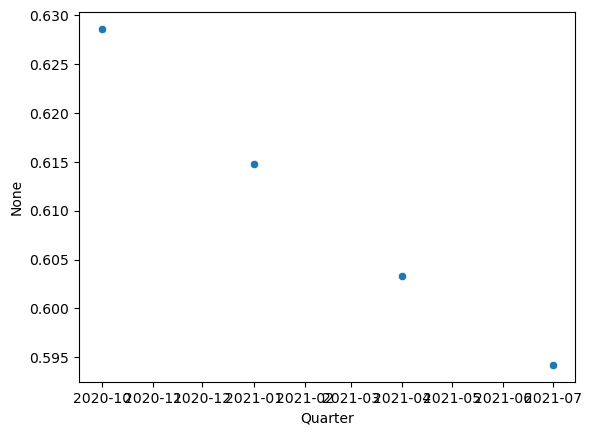

In [7]:
sns.scatterplot(x=rates.index.astype("datetime64[ns]"), y=rates)
plt.show()

### ii. How many customers attempted a deposit of $50 in Sept 2021?

In [8]:
# Filter by date and payment amount, then count unique CustomerIDs.
is_month = payments_df["Attempt Timestamp"].dt.month == 9
is_year = payments_df["Attempt Timestamp"].dt.year == 2021
is_amount = payments_df["Amount"] == 50
users = payments_df[is_month & is_year & is_amount]["CustomerID"]
distinct_attempts = len(users.unique())
total_attempts = len(users)

In [9]:
print(
    f"There were {distinct_attempts} distinct clients, among {total_attempts} total attempts."
)

There were 1803 distinct clients, among 2170 total attempts.


### iii.How much did the group identified in QUESTION 2 successfully deposit during the month?

In [10]:
# Filter again, also by transaction approval, don't filter $50 transactions and distinct customers.
is_approved = payments_df["Appr?"] == 1
amounts = payments_df[is_month & is_year & is_approved]["Amount"]
print(f"The total transacted amount is ${amounts.sum() :,.2f}.")

The total transacted amount is $867,296.57.


### iv. Of the 10 issuing banks with the most deposit attempts between $150.00 and $999.99 in 2021, which had the highest approval rate for the attempts of that deposit amount?

In [11]:
# Filter by deposit amount and year. Group by bank, count attempts.
is_in_range = (payments_df["Amount"] >= 150) & (payments_df["Amount"] < 1000)
is_year = payments_df["Attempt Timestamp"].dt.year == 2021
top_banks = list(
    payments_df[is_in_range & is_year]
    .groupby("Issuing Bank")["Issuing Bank"]
    .count()
    .sort_values(ascending=False)
    .head(10)
    .index
)

In [12]:
# Filter by amount, year, and bank. Calculate approval rate.
is_top_bank = payments_df["Issuing Bank"].isin(top_banks)
grouped_df = (
    payments_df[is_in_range & is_year & is_top_bank]
    .groupby("Issuing Bank")
    .agg({"Appr?": ["sum", "count"]})
)
grouped_df.columns = grouped_df.columns.droplevel(0)
rates = grouped_df["sum"] / grouped_df["count"]
print(rates)
print(
    f"The top issuing bank with highest approval rate between $150.00 and $999.99 from 2021 is {rates.idxmax()}"
)

Issuing Bank
BANK1000    0.607072
BANK1001    0.536318
BANK1002    0.697854
BANK1004    0.498965
BANK1006    0.500000
BANK1010    0.608262
BANK1013    0.402821
BANK1015    0.486667
BANK1017    0.407407
BANK1019    0.562827
dtype: float64
The top issuing bank with highest approval rate between $150.00 and $999.99 from 2021 is BANK1002


### v. Without performing any analysis, which two parameters would you suspect of causing the successive quarterly decrease in approval rate? Why?

I would expect the most influential factor would be the Deposit Amount. As the time goes on, people might have different spending habits and would most likely spend more later as they settle into a spending routine. Greater transaction amounts (both inside and outside of the platform) are likely inversely correlated with approval, and so attempted transactions later in time would be most likely to fail. Insufficient funds and accelerated spending would moslikely result in more rejected transactions.

I would also expect the Website to which customers submit their payment to be of great influence. As the time goes on, users might migrate from one platform to another and as such would inevitably face some friction in performing their transactions. Not only would a bank likely flag these changes as fraud, the customers themselves might make mistakes in registering their information to a new website. Beyond that, a few platforms are likely to move the most volume by transaction amount and transaction count, and so these are likely to have a different approval rate with respect to other websites.

### vi. Identify and describe two main causal factors of the decline in approval rates seen in Q3 2021 vs Q4 2021?

Without getting into predictive or inferential models, I identify the most influential factors according to the mutual information metrix.
In order to quantify the effect to which each feature in the dataset influences the approval of a transaction, relative to the quarter it was performed in, I introduce a binary variable, indicative of the quarter, and calculate it's interaction (by product of the variables) with all other features. This analysis would allow us to identify the most significant interaction and, thus, the more influential feature between quarters.

In [13]:
# Filter create dummy quarter flag. Drop irrelevant features.
payments_df_quarters = payments_df[
    (payments_df["Attempt Timestamp"].dt.quarter.isin([3, 4]))
].drop(["CustomerID", "Attempt Timestamp"], axis=1)

In [14]:
payments_df_quarters["Q4"] = (payments_df_quarters["Quarter"].dt.quarter == 4).astype(
    int
)
payments_df_quarters.drop("Quarter", inplace=True, axis=1)

In [15]:
# Encode categorical variables as ordinal by frequency, for feature interaction and later effect estimation.
encoders_store = dict()
for feature in ["Co Website", "Processing Co", "Issuing Bank", "Amount"]:
    encoder = (
        payments_df_quarters.groupby(feature)[feature].count()
    ) / payments_df_quarters.shape[0]

    payments_df_quarters[feature] = payments_df_quarters[feature].apply(
        lambda x: encoder[x]
    )

In [16]:
# Add feature interactions.
for feature in ["Co Website", "Processing Co", "Issuing Bank", "Amount"]:
    payments_df_quarters[f"Q4:{feature}"] = (
        payments_df_quarters["Q4"] * payments_df_quarters[feature]
    )

In [17]:
# Mutual information:
X = payments_df_quarters.drop("Appr?", axis=1)
y = payments_df_quarters["Appr?"]

In [18]:
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

In [19]:
mi = mutual_info_regression(X, y)
mi /= np.max(mi)

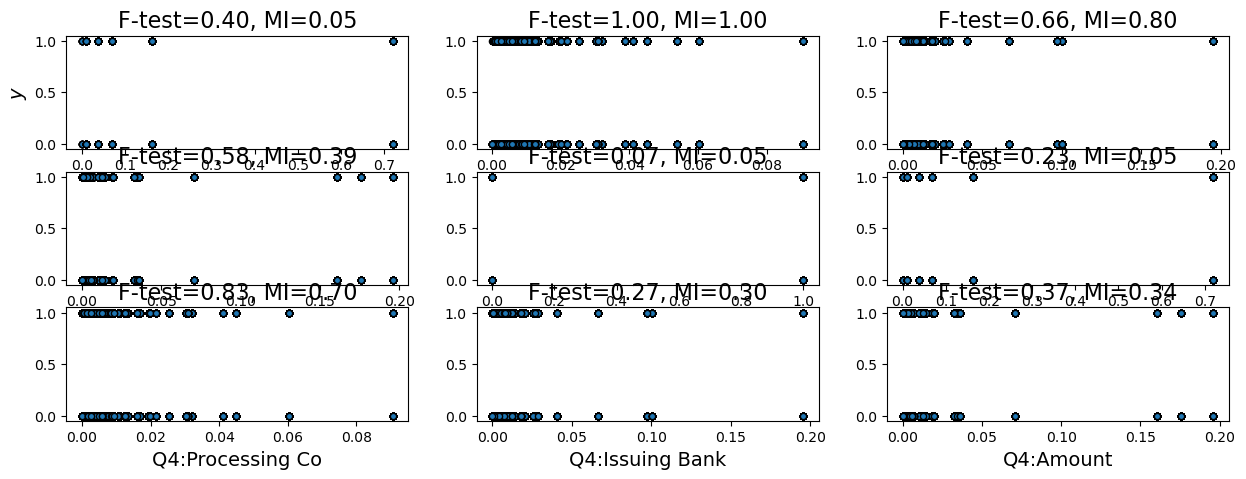

In [20]:
plt.figure(figsize=(15, 5))
for i, v in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    plt.scatter(X[v], y, edgecolor="black", s=20)
    plt.xlabel(v, fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)
plt.show()

Because the relation between the pedictive variables and the response variables is most likely not linear, we should trust the Mutual Information more than the F-statistic which assumes a linear relationship. The most influential feature is the Processing Company, most likely because of how unbalanced the data is. A more in-depth analysis would allow for data balancing techniques. However, we care not about the most influential feature in general to predict the approval of a transaction, but the most influential for the change in approval rate between quarters.

The most important interactions are the those with Processing Co and Issuing Bank, with Amount closely following behind. At this stage, we cannot yet tell the relation between Approval Rate and these interactions, only that these are greatly influential.

### vii. Choose one of the main factors identified in QUESTION 6. How much of the approval rate decline seen in Q3 2021 vs Q4 2020 is explained by this factor?

To identify the relationship between a feature and its response variable, we must establish a statistical model. Let's start with a logistic regression of the Appr? variable as a function of all other features and the interactions with the Q4 flag. We allow for a regularization term as the variables are definitely mutualy correlated.

In [21]:
lgm = LogisticRegression(random_state=0).fit(X, y)
print(lgm.score(X, y))

0.6301973716918284


Our naive first model is able to predict the approval of any transaction with close to 63% accuracy. I would like to further refine the model but will keep from doing so due to time constraints. Let's evaluate the coefficients and identify the effect of a relevant interaction on approval.

In [22]:
coefficients = pd.Series({v: lgm.coef_[0][i] for i, v in enumerate(X.columns)})
print(coefficients)

Co Website          0.517901
Processing Co       5.816266
Issuing Bank        3.761224
Amount              2.489901
Q4                 -0.007840
Q4:Co Website       0.031324
Q4:Processing Co    6.092355
Q4:Issuing Bank    -1.593583
Q4:Amount           0.231067
dtype: float64


The coefficients suggest that as users perform transactions with the more popular banks, in Q3, the rate at which transactions are approved increases. Specifically, the very same transaction from the least frequent bank, executed by the most frequent bank in Q3, would see an increase in it's Odds of being approved of $e^{3.761}=43$. This same behavior in Q4 would represent an increase of $e^{3.761-1.59}=8.77$, much lower odds. What do we make of this? Customers changing banks had a much bigger effect on the rate at which transactions where apprroved in 2021Q3, than it did in 2020Q4. Changing from a less frequent bank to a more frequent bank DOES increase the odds of a transaction being approved, but in recent quarters more than previously.

### viii. If you had more time, which other analyses would you like to perform on this dataset to identify additional causal factors to those identified in QUESTION 6.

Our analysis so far has concluded that users changing banks has the potential to severely influence the rate at which transactions are approved. What remains, is to evaluate to what extent people have been changing banks. If people have, and the composition of transactions became more homogeneous across banks, that would explain why transaction approvals have been on decline. On the other hand, if the composition of transactions has become less homogeneous, and people have been migrating toward the more common banks, we will have come across a contradiction in our results as the expected effect would be an increase in overall transaction rate as the Odds increase. As such, we would have to look at other factors and other interactions with which to explain the decline in approval rate. Also, the accuracy of the logistic regression model is good, but not excellent. I would very much like to explore some more refined models, or even just to tune the hyperparameters of the logistic regression.

More over, this analysis would be well accompanied by more in depth and attractive visualizations with which to explain trends and interactions between variables. Visualization is time consuming, but, if given the time, a Dashboard built on Dash or PowerBI could help communicate this information to an audience less familiar with statistics.

Uploading the data to a server (temptatively as a SQL database) to easily access remotely and keep up to date as a single source of truth would also be quite beneficial for the long term applicability of the study.